In [1]:
import numpy as np
import scipy as sp
from scipy.fft import fft2
from scipy.fft import ifft2
from scipy.fft import fftfreq
from scipy.fft import fftshift
import imageio
import cv2

import matplotlib.pyplot as plt
import scienceplots
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from matplotlib.animation import PillowWriter
import pint

plt.style.use(['science', 'notebook'])
u = pint.UnitRegistry()

# Theory

The theory of scalar Fourier Optics considers a function $U(x,y,z,t)$ that satisfies

$$\left(\nabla^2 - \frac{1}{c^2} \frac{\partial^2}{\partial t^2}\right) U(x,y,z,t) = 0$$

and where $|U|^2$ is the intensity of the light. In some cases, $U$ can be thought of as the dominant component of the electric/magnetic field (i.e. $E_x$ for plane waves). In other cases, it is more difficult to interpret.

For light of a frequency $\omega=2 \pi f$ (monoenergetic, all light is the same frequency) one can look for solutions of the form $U = u(x,y,z)e^{-i\omega t}$ which yields the equation

$$\nabla^2 u + k^2 u =0 \hspace{10mm} k = \omega/c = 2 \pi f / c = 2 \pi / \lambda$$

$|u|^2$ represents the intensity of light at a given point. This is the equation, **The Helmholtz Equation**, is what we need to solve. We start by looking for solutions that are seperable ($s$ for seperable):

$$u_s(x, y, z) = f_x(x) \times f_y(y) \times f_z(z)$$

i.e., as the product of a function of ''x'', times a function of ''y'', times a function of ''z''. (*The general solution for a particular problem won't be seperable, but it can be written as the sum of infinitely many seperable solutions*). It follows that

$$ \nabla^2 u_s = \frac{\partial^2 u_s}{\partial x^2} + \frac{\partial^2 u_s}{\partial y^2} + \frac{\partial^2 u_s}{\partial z^2}  $$

and the following equation for the 3 individual functions is obtained

$$ f''_x(x)f_y(y)f_z(z) + f_x(x)f''_y(y)f_z(z) + f_x(x)f_y(y)f''_z(z) + k^2f_x(x)f_y(y)f_z(z)=0 $$

which is readily rearranged into the form:

$$ \frac{f''_x(x)}{f_x(x)}+ \frac{f''_y(y)}{f_y(y)} + \frac{f''_z(z)}{f_z(z)} + k^2=0 $$

It may now be argued that each quotient in the equation above must, of necessity, be constant. To justify this, let's say that the first quotient is not a constant, and is a function of ''x''. Since none of the other terms in the equation has any dependence on the variable ''x'', the first term also must not have any ''x''-dependence; it must be a constant. (If the first term is a function of ''x'', then there is no way to make the left hand side of this equation be zero.) This constant is denoted as -''k''<sub>x</sub>². Reasoning in a similar way for the ''y'' and ''z'' quotients, three ordinary differential equations are obtained for the ''f''<sub>x</sub>, ''f''<sub>y</sub> and ''f''<sub>z</sub>, along with one ''separation condition'':

$$ \frac{d^2}{dx^2}f_x(x) + k_x^2 f_x(x)=0 $$

$$ \frac{d^2}{dy^2}f_y(y) + k_y^2 f_y(y)=0 $$

$$ \frac{d^2}{dz^2}f_z(z) + k_z^2 f_z(z)=0 $$

$$ k_x^2+k_y^2+k_z^2= k^2 $$

Each of these 3 differential equations has the same solution form: sines, cosines or complex exponentials. We'll go with the complex exponentials,

$$ u_s(x,y,z)=Ae^{ik_x x}e^{ik_y y}e^{ik_z z} $$
$$ \implies u_s(x,y,z) =Ae^{i(k_x x + k_y y)} e^{\pm i z \sqrt{k^2-k_x^2-k_y^2} } $$

with a generally complex number $A$. To get the general solution, one needs to take a linear combination of all seperable solutions (infinitely many of them so need an integral as a sum):

$$u(x,y,z) = \iint_{-\infty}^{\infty} u_s(x,y,z,k_x,k_y) dk_x dk_y $$

Note that each seperable solution is specified by its value of $k_x$ and $k_y$, so we denote the corresponding amplitude as $A(k_x, k_y)$:

$$ u(x,y,z)=\int_{-\infty}^{+\infty}    \int_{-\infty}^{+\infty}      A(k_x,k_y) ~ e^{i(k_x x + k_y y)} ~ e^{\pm i z \sqrt{k^2-k_x^2-k_y^2} } ~ dk_x dk_y  $$

Now note that

$$ u(x,y,0)=\int_{-\infty}^{+\infty}      \int_{-\infty}^{+\infty}  A(k_x,k_y) ~ e^{i(k_x x + k_y y)}  ~ dk_x dk_y $$

This implies that $A(k_x, k_y)$ is the Fourier transform of $u$ at $z=0$

$$\boxed{A(k_x, k_y) = \mathcal{F}[u(x,y,0)]}$$

Note that the original expression

$$ u(x,y,z)=\int_{-\infty}^{+\infty}    \int_{-\infty}^{+\infty} A(k_x, k_y) ~ e^{i(k_x x + k_y y)} ~ e^{\pm i z \sqrt{k^2-k_x^2-k_y^2} } ~ dk_x dk_y  $$

which itself is an inverse Fourier transform of $ A(k_x, k_y) e^{\pm i z \sqrt{k^2-k_x^2-k_y^2} }$, so we can write

$$\boxed{u(x,y,z) = \mathcal{F}^{-1}\left[A(k_x, k_y) e^{- i z \sqrt{k^2-k_x^2-k_y^2} }\right]}$$

We choose the $-$ sign in the $\pm$ because we consider waves moving through the slit. Using the two boxed equation, everything can be solved for provided one knows

* $k$, which is related to the wavelength of the light
* $u(x,y,z=0)$, which is given by the distribution of light as it exists the slit.



# Experiment 1: The Single Slit

Set the slit parameters, including slit distance and wavelength:

In [2]:
D = 0.1 * u.mm
lam = 660 * u.nm

Define the spatial grid, which goes from -2mm to 2mm in 1600 steps (x and y).

In [3]:
x = np.linspace(-2,2,1600) * u.mm
xv, yv = np.meshgrid(x, x)

Define $u(x,y,0)$; in all examples the variable will be `U0`. In this case we want this to be a rectangular slit.

In [4]:
U0 = (np.abs(xv)< D/2) * (np.abs(yv)<0.5*u.mm)
U0 = U0.astype(float)

Plot `U0`:

C:\Users\fangy\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook.py:733: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.array(x, subok=True, copy=copy)


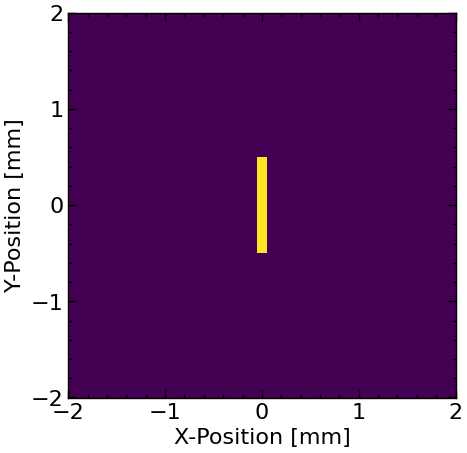

In [5]:
plt.figure(figsize=(5,5))
plt.pcolormesh(xv,yv,U0)
plt.xlabel('X-Position [mm]')
plt.ylabel('Y-Position [mm]')
plt.show()

Now we need to get $A(k_x, k_y)$ given by the first boxed equation above. In addition, we need a meshgrid of $k_x$ and $k_y$ values so we can eventually compute $e^{- i z \sqrt{k^2-k_x^2-k_y^2}}$ (which needs to be a 2D array). 

In [6]:
A = fft2(U0)
kx = fftfreq(len(x), np.diff(x)[0]) * 2 * np.pi # multiply by 2pi to get angular frequency
kxv, kyv = np.meshgrid(kx,kx)

Plot the Fourier transform

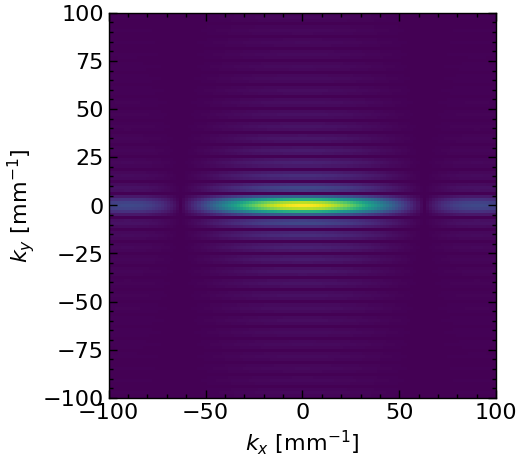

In [7]:
plt.figure(figsize=(5,5))
plt.pcolormesh(fftshift(kxv.magnitude), fftshift(kyv.magnitude), np.abs(fftshift(A)))
plt.xlabel('$k_x$ [mm$^{-1}$]')
plt.ylabel('$k_y$ [mm$^{-1}$]')
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.show()

Define the function that returns $u(x,y,z)$. It depends on the $z$ distance from the slit and $k=2\pi/\lambda$ (wavelength of light).

In [8]:
def get_U(z,k):
    return ifft2(A*np.exp(1j*z*np.sqrt(k**2-kxv**2-kyv**2)))

Specify the distance from the slit to the screen $z=d$ and $k$:

In [9]:
k = 2*np.pi / (lam)
d = 3* u.cm

Get value of $U$:

In [10]:
U = get_U(d,k)

c:\Users\fangy\miniconda3\lib\site-packages\scipy\fft\_pocketfft\helper.py:103: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(x, dtype=dtype, copy=copy)


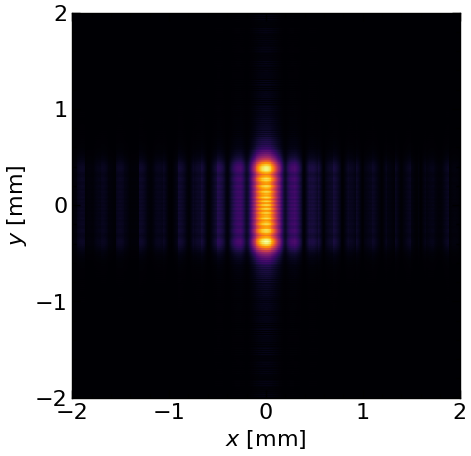

In [11]:
plt.figure(figsize=(5,5))
plt.pcolormesh(xv,yv,np.abs(U), cmap='inferno')
plt.xlabel('$x$ [mm]')
plt.ylabel('$y$ [mm]')
plt.show()

For the single slit experiment, minima of intensity occur at angles $\theta$ (slit and screen) such that

$$D\sin\theta = m\lambda$$

where $D$ is the slit width and $m$ is a non-zero integer. Noting that

$$\sin\theta = x/\sqrt{x^2 + d^2}$$

where $x$ is the horizontal distance on the screen and $d$ is the distance from the slit to screen, we can solve for the positions $x$ at minima:

$$x = \frac{m \lambda d}{\sqrt{D^2 - m^2 \lambda^2}}$$



Get positions of minima:

In [12]:
m  = np.arange(1,5,1)
x_min = np.sqrt(m**2 * lam**2 * d**2 / (D**2 - m**2 * lam**2)).to('mm')

C:\Users\fangy\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook.py:1398: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


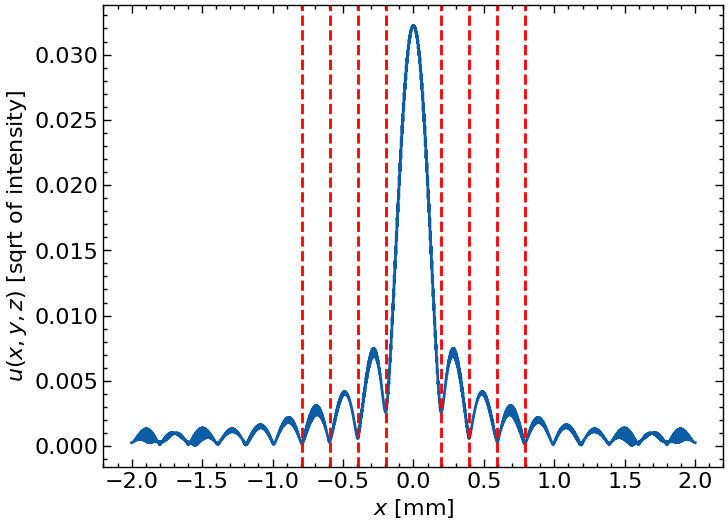

In [13]:
plt.plot(x, np.abs(U)[250])
[plt.axvline(x.magnitude, ls='--', color='r') for x in x_min]
[plt.axvline(-x.magnitude, ls='--', color='r') for x in x_min]
plt.xlabel('$x$ [mm]')
plt.ylabel('$u(x,y,z)$ [sqrt of intensity]')
plt.show()

For future experiments, lets write a function that does everything quickly:

In [14]:
def compute_U(U0, xv, yv, lam, z):
    A = fft2(U0)
    kx = 2*np.pi * fftfreq(len(x), np.diff(x)[0])
    kxv, kyv = np.meshgrid(kx,kx)
    k = 2*np.pi/lam
    return ifft2(A*np.exp(1j*z*np.sqrt(k**2-kxv**2-kyv**2)))

# Experiment 2: The Double Slit

Define distance between slits $s$, slit width $D$, and use this to get initial field $u(x,y,0)$

In [15]:
S = 0.2*u.mm
D = 0.05*u.mm
x = np.linspace(-4,4,3200) * u.mm
xv, yv = np.meshgrid(x, x)

U0 = (np.abs(xv-S/2)< D/2) * (np.abs(yv)<2*u.mm) + (np.abs(xv+S/2)< D/2) * (np.abs(yv)<2*u.mm)
U0 = U0.astype(float)

Show initial field:

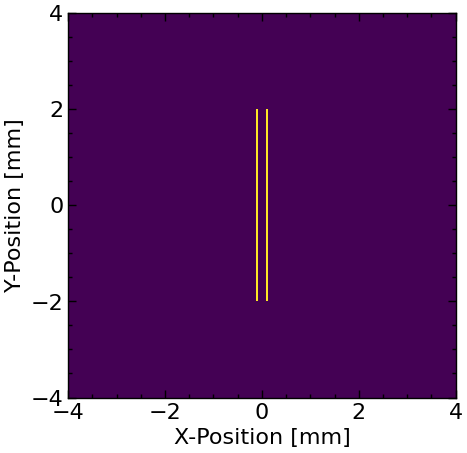

In [16]:
plt.figure(figsize=(5,5))
plt.pcolormesh(xv,yv,U0)
plt.xlabel('X-Position [mm]')
plt.ylabel('Y-Position [mm]')
plt.show()

Compute $u(x,y,z)$ at $z=5~$cm

In [17]:
U = compute_U(U0, xv, yv, lam, z=5*u.cm)

Plot diffraction pattern

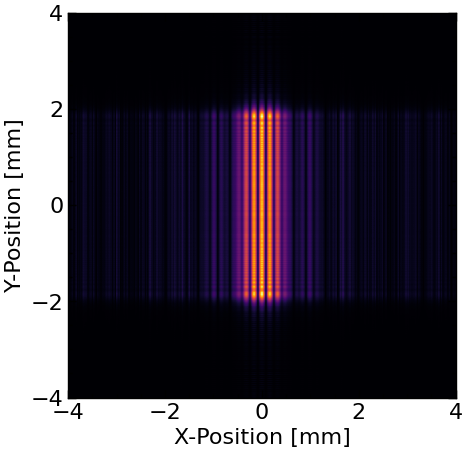

In [18]:
plt.figure(figsize=(5,5))
plt.pcolormesh(xv,yv,np.abs(U), cmap='inferno')
plt.xlabel('X-Position [mm]')
plt.ylabel('Y-Position [mm]')
plt.show()

Lets look at a cross section of this

In [19]:
central_line = np.abs(U)[250]

Plot the field:

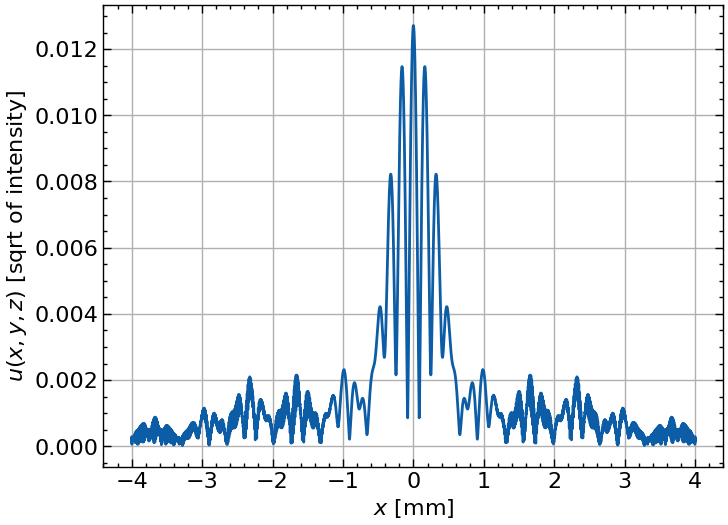

In [20]:
plt.plot(x, central_line)
plt.xlabel('$x$ [mm]')
plt.ylabel('$u(x,y,z)$ [sqrt of intensity]')
plt.grid()

# Experiment 3: Circle

Lets look at the diffraction pattern of a pinhole:

In [21]:
x = np.linspace(-2,2,1600) * u.mm
xv, yv = np.meshgrid(x, x)
R = 0.1*u.mm

U0 = xv**2 + yv**2 < R**2
U0 = U0.astype(float)
U = compute_U(U0, xv, yv, lam, z=5*u.cm)

Plot original intensity and intensity on screen:

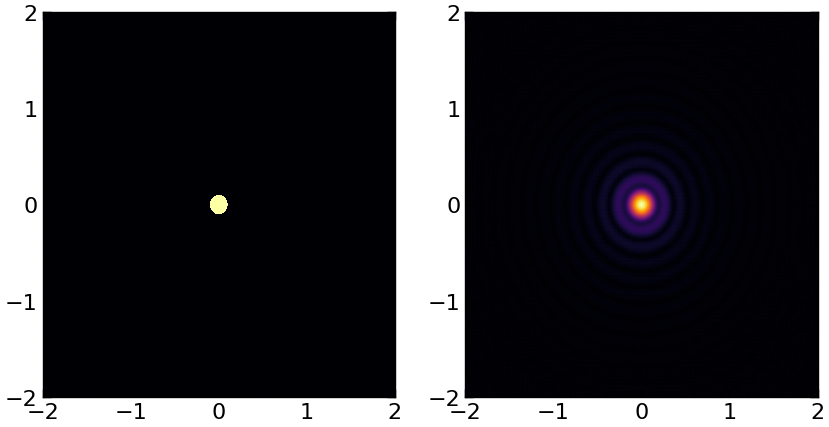

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].pcolormesh(xv,yv,np.abs(U0), cmap='inferno')
ax[1].pcolormesh(xv,yv,np.abs(U), cmap='inferno')
plt.show()

# Experiment 4: Different Wavelengths

Lets see how the diffraction pattern changes for different wavelengths going through a hexagonal pinhole structure:

In [23]:
img = cv2.imread('../images/hexagon.jpg')
img = np.pad(img, 200, mode='constant')
img = cv2.resize(img, dsize=(1600, 1600), interpolation=cv2.INTER_CUBIC)
U0 = np.array(img).sum(axis=2).astype(float)
lam1 = 400*u.nm
lam2 = 500*u.nm
lam3 = 600*u.nm
lam4 = 700*u.nm

x = np.linspace(-2,2,U0.shape[0]) * u.mm
xv, yv = np.meshgrid(x, x)

U_new1 = compute_U(U0, xv, yv, lam=lam1, z=6*u.cm)
U_new2 = compute_U(U0, xv, yv, lam=lam2, z=6*u.cm)
U_new3 = compute_U(U0, xv, yv, lam=lam3, z=6*u.cm)
U_new4 = compute_U(U0, xv, yv, lam=lam4, z=6*u.cm)

This function takes in a wavelength and converts it to a color that can be seen on a computer screen. It is useful for showing the different colors of the diffracted light.

In [24]:
def wavelength_to_rgb(wavelength, gamma=0.8):
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    #R *= 255
    #G *= 255
    #B *= 255
    return (R, G, B)

Define custom colormaps to show the light:

In [25]:
cmaps = [LinearSegmentedColormap.from_list('custom', 
                                         [(0,0,0),wavelength_to_rgb(lam.magnitude)],
                                         N=256) for lam in [lam1, lam2, lam3, lam4]]

Plot:

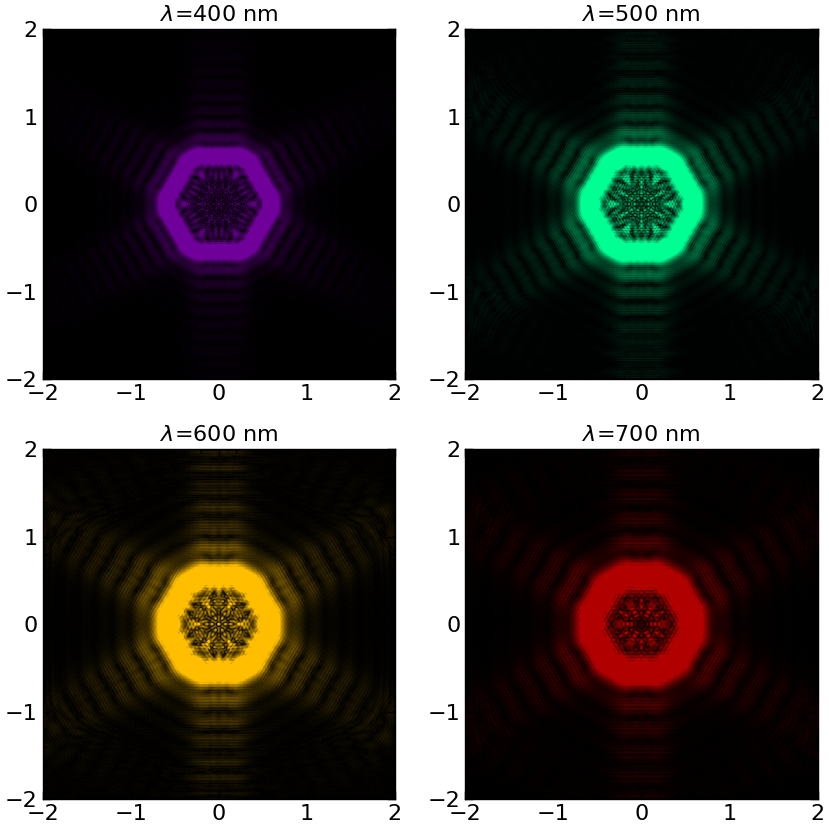

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0,0].pcolormesh(xv,yv,np.abs(U_new1), cmap=cmaps[0], vmax=np.max(np.abs(U_new1))/2)
ax[0,1].pcolormesh(xv,yv,np.abs(U_new2), cmap=cmaps[1], vmax=np.max(np.abs(U_new2))/2)
ax[1,0].pcolormesh(xv,yv,np.abs(U_new3), cmap=cmaps[2], vmax=np.max(np.abs(U_new3))/2)
ax[1,1].pcolormesh(xv,yv,np.abs(U_new4), cmap=cmaps[3], vmax=np.max(np.abs(U_new4))/2)

ax[0,0].set_title('$\lambda$={} nm'.format(lam1.magnitude))
ax[0,1].set_title('$\lambda$={} nm'.format(lam2.magnitude))
ax[1,0].set_title('$\lambda$={} nm'.format(lam3.magnitude))
ax[1,1].set_title('$\lambda$={} nm'.format(lam4.magnitude))
plt.show()

We can also turn this into an animation for 1 of the wavelengths:

0
0


c:\Users\fangy\miniconda3\lib\site-packages\scipy\fft\_pocketfft\helper.py:103: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(x, dtype=dtype, copy=copy)


10
20
30
40
50
60
70
80
90
0


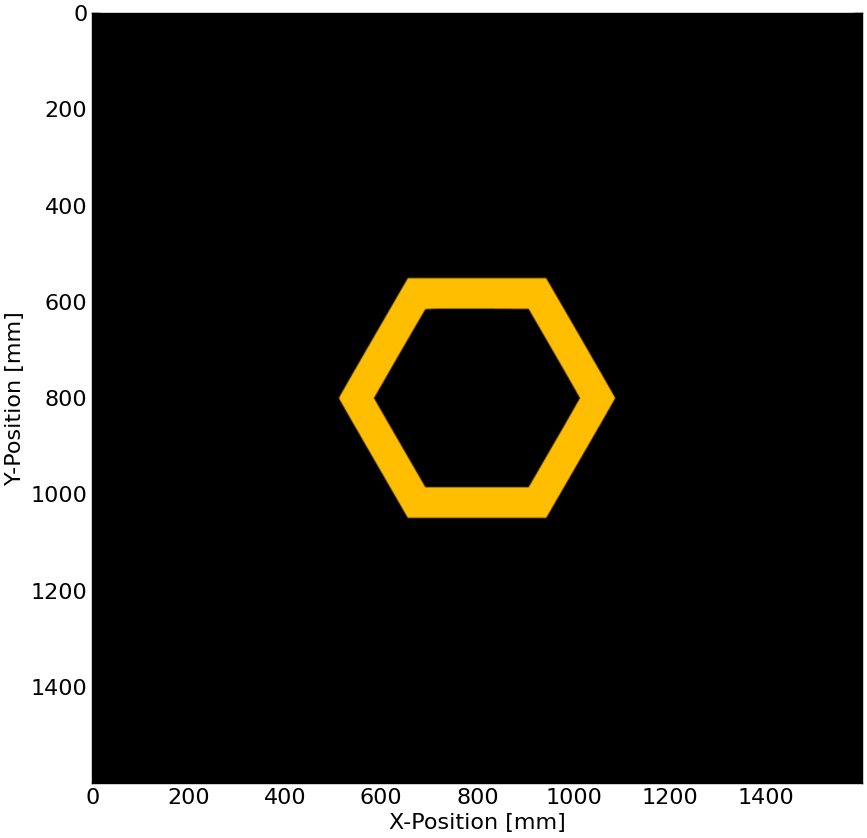

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel('X-Position [mm]')
ax.set_ylabel('Y-Position [mm]')


def animate(i):
    if i % 10 == 0:
        print(i)
    U = compute_U(U0, xv, yv, lam=lam3, z=0.06*i*u.cm)
    ax.imshow(np.abs(U), cmap=cmaps[2])


ani = animation.FuncAnimation(fig, animate, frames=100, interval=50)
ani.save('ani3.gif', writer='pillow', fps=10, dpi=100)